# Cook's membrane

## Implementation

### Mesh creation in `gmsh`, functional setup
We start by creating the mesh with `gmsh`, through its python interface (note that this may require that you install the python packages `gmsh` and `python-gmsh`).

In [29]:
from mpi4py import MPI
import gmsh

import pyvista
gmsh.initialize()

We now create the quadrilateral domain in gmsh. We start by creating the points, le line connecting them, then finally the surface of the domain. 

We can associate to each point a mesh size (`lc` variable). If `lc`$=0$, or if it is not set, we do not specify any constraint.

In [30]:
gmsh.clear()
gdim = 2

# the quadrilateral domain 
lc = 0
p1 = gmsh.model.geo.addPoint(0, 0, 0, lc)
p2 = gmsh.model.geo.addPoint(48, 44, 0, lc)
p3 = gmsh.model.geo.addPoint(48, 60, 0, lc)
p4 = gmsh.model.geo.addPoint(0, 44, 0, lc)
l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p1)
cl = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])
ps = gmsh.model.geo.addPlaneSurface([cl])
gmsh.model.geo.synchronize()
gmsh.model.addPhysicalGroup(gdim, [ps], tag=1)

Info    : Clearing all models and views...
Info    : Done clearing all models and views


1

We generate the mesh.

In [31]:
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 1)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 1.2)

gmsh.model.mesh.generate(gdim)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00051775s, CPU 0.001107s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.01966s, CPU 0.019736s)
Info    : 1296 nodes 2594 elements


We now import the mesh into dolfinx.

In [32]:
from dolfinx.io import gmsh as gmshio
from mpi4py import MPI


gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
mesh_data = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=2)
domain = mesh_data.mesh
cell_markers = mesh_data.cell_tags
facet_markers = mesh_data.facet_tags


We import the same packages as for the linear elasticity example. 

In [33]:
# comment following line if having problems
pyvista.set_jupyter_backend('html')
# To remove interactivity in the plots, use
# pyvista.set_jupyter_backend('static')
from dolfinx import mesh, fem, plot, io, default_scalar_type, geometry
from dolfinx.fem.petsc import LinearProblem
from mpi4py import MPI
import ufl
import numpy as np

We create the function space. As in the elasticity example, we want $2$-dimensional vectors of functions.

In [34]:
V = fem.functionspace(domain, ("Lagrange", 1, (domain.topology.dim, )))

We plot the mesh.

In [35]:
## Uncomment the following line if using the docker image
# pyvista.start_xvfb()
p = pyvista.Plotter()
topology, cell_types, dom_geometry = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, dom_geometry)
p.add_mesh(grid, style="wireframe", color="k")
p.camera_position = 'xy'
p.show()


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

## Boundary conditions
As we would like to clamp the boundary at $x=0$, we do this by using a marker function, which locate the facets where $x$ is close to zero by machine precision.

In [36]:
def clamped_boundary(x):
    return np.isclose(x[0], 0)


edim = domain.topology.dim - 1
boundary_edge = mesh.locate_entities_boundary(domain, edim, clamped_boundary)

u_D = np.array([0, 0], dtype=default_scalar_type)
bc = fem.dirichletbc(u_D, fem.locate_dofs_topological(V, edim, boundary_edge), V)

We define the traction $T$ over the remaining boundary. It is zero on two edges, while it is equal to $1/16$ over the remaining one, see the lecture notes. We identify the edges and define the constant tractions. We define boudary measures on different parts of the boundary, see https://jsdokken.com/dolfinx-tutorial/chapter3/robin_neumann_dirichlet.html

In [37]:
def zero_traction(x):
    return np.isclose(x[1],11./12*x[0]) | np.isclose(x[1]-x[0]/3,44)

def unif_traction(x):
    return np.isclose(x[0], 48.)

zt_mark = 1
ut_mark = 2
edges = [(zt_mark, zero_traction), (ut_mark, unif_traction)]

def create_facet_tags(domain, edges):
    facet_indices, facet_markers = [], []
    fdim = domain.topology.dim - 1
    for (marker, locator) in edges:
        facets = mesh.locate_entities_boundary(domain, fdim, locator)
        facet_indices.append(facets)
        facet_markers.append(np.full_like(facets, marker))
    facet_indices = np.hstack(facet_indices).astype(np.int32)
    facet_markers = np.hstack(facet_markers).astype(np.int32)
    sorted_facets = np.argsort(facet_indices)
    facet_tag = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])
    return facet_tag


domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)
# with io.XDMFFile(domain.comm, "facet_tags.xdmf", "w") as xdmf:
#     xdmf.write_mesh(domain)
#     xdmf.write_meshtags(facet_tag, domain.geometry)
    

Tzero = fem.Constant(domain, default_scalar_type((0, 0)))
Tunif = fem.Constant(domain, default_scalar_type((0, 1./16)))

We now create two boundary measures, one on the zero traction edges, the other on the constant traction edge. We will be able to access the measure through `ds(ut_mark)` and `ds(zt_mark)`.

In [38]:
ds = ufl.Measure("ds", domain=domain, subdomain_data=create_facet_tags(domain, edges))

## Variational formulation
We define our parameters.

In [39]:
lambda_ = 0.750
mu = 0.375

We are now ready to create our variational formulation in close to mathematical syntax, as for the previous problems.

In [40]:
def epsilon(u):
    return ufl.sym(ufl.grad(u))  # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)


def sigma(u):
    return lambda_ * ufl.nabla_div(u) * ufl.Identity(len(u)) + 2 * mu * epsilon(u)


u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
f = fem.Constant(domain, default_scalar_type((0, 0)))
a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx

L = ufl.dot(f, v) * ufl.dx + ufl.dot(Tzero, v) * ds(zt_mark) + ufl.dot(Tunif, v) * ds(ut_mark)


## Solve the linear variational problem
As in the previous demos, we assemble the matrix and right hand side vector and use PETSc to solve our variational problem

In [41]:
problem = LinearProblem(a, L, bcs=[bc], 
                        petsc_options={"ksp_type": "preonly", "pc_type": "lu"},
                        petsc_options_prefix="cook",
                       )
uh = problem.solve()

## Visualization

We plot the displaced membrane, adding a fictititous third dimension because the function `warp_by_vector` only works for three dimensional input data.

In [42]:
# pyvista.start_xvfb()


uh_copy = uh
# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, dom_geometry = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, dom_geometry)

# warp by vector only works in 3d: the following code is a workaround
vals_2D = uh_copy.x.array.reshape(int(uh.x.array.shape[0]/2),2)
vals = np.zeros((vals_2D.shape[0], 3))
vals[:,:2] = vals_2D
grid["u"] = vals
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1)
actor_1 = p.add_mesh(warped, show_edges=True)
p.view_xy()

if not pyvista.OFF_SCREEN:
    p.show()
else:
    figure_as_array = p.screenshot("deflection.png")

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

## Evaluation at a point
We evaluate the computed displacement at the point
$$
A = (48, 52)
$$
and compare with the quantity
$$
u(A) = \begin{pmatrix}
-9.5775\\
21.520
\end{pmatrix}.
$$
We use the procedure described in https://jsdokken.com/dolfinx-tutorial/chapter1/membrane_code.html#making-curve-plots-throughout-the-domain

In [43]:
point = np.array([48, 52, 0])

def find_cell_for_one_point(domain, point):
    bb_tree = geometry.bb_tree(domain, domain.topology.dim)
    cells = []
    points_on_proc = []
    # Find cells whose bounding-box collide with the the points
    cell_candidates = geometry.compute_collisions_points(bb_tree, point.T)
    # Choose one of the cells that contains the point
    colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, point.T)

    cells.append(colliding_cells.links(0)[0])

    return cells

uh.eval(point, find_cell_for_one_point(domain, point))

array([-9.57918159, 21.52296957])

## Convergence when increasing the number of degrees of freedom
We wrap all the previous code into a function, to be able to run it for differente mesh sizes and compare with the exact value.

In [49]:
def solve_cook(mesh_width):
    gmsh.clear()
    gdim = 2
    
    # the quadrilateral domain 
    lc = 0
    p1 = gmsh.model.geo.addPoint(0, 0, 0, lc)
    p2 = gmsh.model.geo.addPoint(48, 44, 0, lc)
    p3 = gmsh.model.geo.addPoint(48, 60, 0, lc)
    p4 = gmsh.model.geo.addPoint(0, 44, 0, lc)
    l1 = gmsh.model.geo.addLine(p1, p2)
    l2 = gmsh.model.geo.addLine(p2, p3)
    l3 = gmsh.model.geo.addLine(p3, p4)
    l4 = gmsh.model.geo.addLine(p4, p1)
    cl = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])
    ps = gmsh.model.geo.addPlaneSurface([cl])
    gmsh.model.geo.synchronize()
    gmsh.model.addPhysicalGroup(gdim, [ps], tag=1)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", mesh_width)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 1.2*mesh_width)

    gmsh.model.mesh.generate(gdim)
    gmsh_model_rank = 0
    mesh_comm = MPI.COMM_WORLD
    mesh_data = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=2)
    domain = mesh_data.mesh
    cell_markers = mesh_data.cell_tags
    facet_markers = mesh_data.facet_tags
    
    facet_tag = create_facet_tags(domain, edges)
    
    domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)
    
    Tzero = fem.Constant(domain, default_scalar_type((0, 0)))
    Tunif = fem.Constant(domain, default_scalar_type((0, 1./16)))
    
    ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tag)

    V = fem.functionspace(domain, ("Lagrange", 1, (domain.topology.dim, )))
    edim = domain.topology.dim - 1
    boundary_edge = mesh.locate_entities_boundary(domain, edim, clamped_boundary)
    
    u_D = np.array([0, 0], dtype=default_scalar_type)
    bc = fem.dirichletbc(u_D, fem.locate_dofs_topological(V, edim, boundary_edge), V)

        
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)
    f = fem.Constant(domain, default_scalar_type((0, 0)))
    a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx
    
    L = ufl.dot(f, v) * ufl.dx + ufl.dot(Tzero, v) * ds(zt_mark) + ufl.dot(Tunif, v) * ds(ut_mark)
    problem = LinearProblem(a, L, bcs=[bc], 
                            petsc_options={"ksp_type": "preonly", "pc_type": "lu"},
                            petsc_options_prefix="cook",)
    uh = problem.solve()

    return uh, V, domain

We introduce a function that returns the number of degrees of freedom of a FE space

In [50]:
def n_dofs(V):
    return V.dofmap.index_map.size_global * V.dofmap.index_map_bs

We run the solver for different mesh sizes, compute the value at the specified point, and compute the error with respect to the "exact" value that we have been given. We solve the problem with characteristing mesh sizes
$$
h_i = 10^{\beta_i}, \qquad \beta_i \text{ uniformly distributed in }[-0.8, 0.5].
$$
The reason for this choice (instead of linearly distributed mesh sizes) will become clear in the sequel.

In [51]:
point = np.array([48, 52, 0])
exact_value = np.array([-9.5775, 21.52])
uh_vals = []
ndofs = []
errs = []

for h in np.logspace(-0.8, 0.5, 10):
    print(f"Solving problem with h={h}")
    uh, V, domain = solve_cook(h)
    cell = find_cell_for_one_point(domain, point)
    this_val = uh.eval(point, cell)
    uh_vals.append(this_val)
    ndofs.append(n_dofs(V))
    errs.append(np.linalg.norm(exact_value-this_val))

Solving problem with h=0.15848931924611134
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000823209s, CPU 0s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 1.10976s, CPU 1.11043s)
Info    : 46912 nodes 93826 elements
Solving problem with h=0.22102654979706374
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00275071s, CPU 0.003968s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info   

We plot the behaviour of the error vs. the number of degrees of freedom of the numerical method

<>:5: SyntaxWarning: invalid escape sequence '\|'
<>:5: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipykernel_161/2060819743.py:5: SyntaxWarning: invalid escape sequence '\|'
  plt.ylabel("$\|\cdot\|_2$ norm of the error at the selected point")


Text(0, 0.5, '$\\|\\cdot\\|_2$ norm of the error at the selected point')

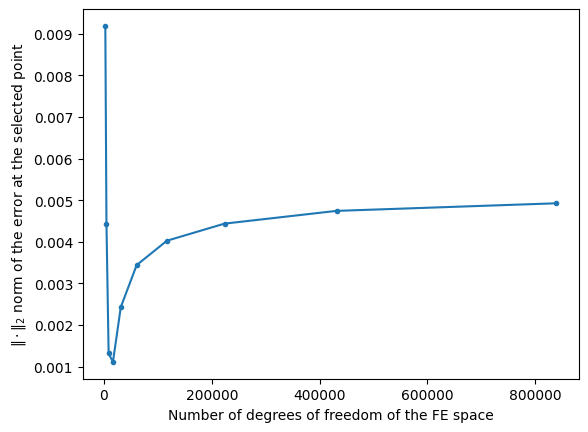

In [52]:
import matplotlib.pyplot as plt

plt.plot(ndofs, errs, '.-')
plt.xlabel("Number of degrees of freedom of the FE space")
plt.ylabel("$\|\cdot\|_2$ norm of the error at the selected point")

Since the convergence is fast (in particular, it is algebraic: there exists $\alpha>0$ such that $\mathrm{err}\sim N^{-\alpha}$, it can be better visualized if we do the plot in a log-log scale

<>:3: SyntaxWarning: invalid escape sequence '\|'
<>:3: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipykernel_161/3372782295.py:3: SyntaxWarning: invalid escape sequence '\|'
  plt.ylabel("$\|\cdot\|_2$ norm of the error at the selected point")


Text(0, 0.5, '$\\|\\cdot\\|_2$ norm of the error at the selected point')

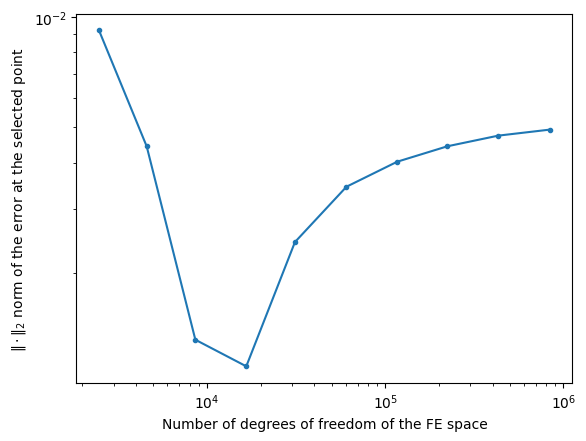

In [53]:
plt.loglog(ndofs, errs, '.-')
plt.xlabel("Number of degrees of freedom of the FE space")
plt.ylabel("$\|\cdot\|_2$ norm of the error at the selected point")